In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import pandas as pd
import sys
sys.path.append("..") # Adds higher directory to python modules path.
sys.path.append("/Users/timothyguo/Desktop/Haeffner Group/Trap Design Testing/DC_Confinement/trap_sim_tools_python_trapSims_HOA/v2")
import expansion as ep
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import time
%matplotlib inline
import trap_util as tu
from trap_util import trap
from trap_util import quarter_trap
from trap_util import half_trap
import numpy.fft as fft
# physical parameters
qe = -1.60217662e-19 # coulombs
m = 9.10938356e-31 #kg (electron)
kB = 1.38064852e-23 # J/K
ramp_time = 5.0e-9 #s (the ramping time for extraction voltage)
f = 1.5e9 # Electrode frequency, in Hertz
fz = 100.0e6 #Hz
omegaz = 2*np.pi*fz

In [2]:
# loading RF E field data
data_RF = np.loadtxt("../etrap_65V_1p5GHz_realsmoothExEy_250nm_30passes_quarter.fld", skiprows = 2)
# manipulating E field data
df_RF = pd.DataFrame(data_RF, columns=['x', 'y', 'z', 'Ex', 'Ey', 'Ez'])
x_max_RF, x_min_RF = df_RF.x.max(), df_RF.x.min()
y_max_RF, y_min_RF = df_RF.y.max(), df_RF.y.min()
# print(x_max, x_min, y_max, y_min)
# print(df.y.nunique())
Nx_RF, Ny_RF = df_RF.x.nunique() - 1, df_RF.y.nunique() - 1 # numbers of intervals that divide each dimension
dx_RF, dy_RF = (x_max_RF-x_min_RF)/Nx_RF, (y_max_RF-y_min_RF)/Ny_RF # interval size
print("x_max = ", x_max_RF*1.0e3, "mm")
print("y_max = ", y_max_RF*1.0e3, "mm")
print("x_min = ", x_min_RF*1.0e3, "mm")
print("y_min = ", y_min_RF*1.0e3, "mm")
print("spatial resolution x: ", dx_RF*1.0e6, "um")
print("spatial resolution y: ", dy_RF*1.0e6, "um")

x_max =  1.0 mm
y_max =  1.5 mm
x_min =  0.0 mm
y_min =  0.0 mm
spatial resolution x:  0.25 um
spatial resolution y:  0.25 um


In [3]:
# # extraction voltage data
# data_DC1 = np.loadtxt("grid_with_ext_voltage_200V_half.fld", skiprows=2)
# # manipulating E field data
# df_DC1 = pd.DataFrame(data_DC1, columns=['x', 'y', 'z', 'Ex', 'Ey', 'Ez'])
# x_max_DC1, x_min_DC1 = df_DC1.x.max(), df_DC1.x.min()
# y_max_DC1, y_min_DC1 = df_DC1.y.max(), df_DC1.y.min()
# # print(x_max, x_min, y_max, y_min)
# # print(df.y.nunique())
# Nx_DC1, Ny_DC1 = df_DC1.x.nunique() - 1, df_DC1.y.nunique() - 1 # numbers of intervals that divide each dimension
# dx_DC1, dy_DC1 = (x_max_DC1-x_min_DC1)/Nx_DC1, (y_max_DC1-y_min_DC1)/Ny_DC1 # interval size
# print("x_max = ", x_max_DC1*1.0e3, "mm")
# print("y_max = ", y_max_DC1*1.0e3, "mm")
# print("x_min = ", x_min_DC1*1.0e3, "mm")
# print("y_min = ", y_min_DC1*1.0e3, "mm")
# print("spatial resolution x: ", dx_DC1*1.0e6, "um")
# print("spatial resolution y: ", dy_DC1*1.0e6, "um")

In [10]:
data_DC0 = np.loadtxt("grid_no_ext_voltage_200V_half.fld", skiprows=2)
# manipulating E field data
df_DC0 = pd.DataFrame(data_DC0, columns=['x', 'z', 'y', 'Ex', 'Ez', 'Ey'])
# dealing with the discrepency between axis notations used by this simulation and Maxwell
df_DC0 = df_DC0[["x", "y", "z", "Ex", "Ey", "Ez"]]
df_DC0[(abs(df_DC0.y)<50.0e-6) & (df_DC0.x==0) & (abs(df_DC0.Ey)<10.0)]

,x,y,z,Ex,Ey,Ez
0,0.0,0.0,-0.002000,-0.510837,0.0,-998.283761
1,0.0,0.0,-0.001999,-0.533701,0.0,-991.871463
2,0.0,0.0,-0.001998,-0.556515,0.0,-985.456350
3,0.0,0.0,-0.001997,-0.579280,0.0,-979.038425
4,0.0,0.0,-0.001996,-0.601994,0.0,-972.617686
5,0.0,0.0,-0.001995,-0.624659,0.0,-966.194133
6,0.0,0.0,-0.001994,-0.647273,0.0,-959.767767
7,0.0,0.0,-0.001993,-0.669838,0.0,-953.338588
8,0.0,0.0,-0.001992,-0.692354,0.0,-946.906595
9,0.0,0.0,-0.001991,-0.714819,0.0,-940.471789


In [6]:
x_max_DC0, x_min_DC0 = df_DC0.x.max(), df_DC0.x.min()
y_max_DC0, y_min_DC0 = df_DC0.y.max(), df_DC0.y.min()
# print(x_max, x_min, y_max, y_min)
# print(df.y.nunique())
Nx_DC0, Ny_DC0 = df_DC0.x.nunique() - 1, df_DC0.y.nunique() - 1 # numbers of intervals that divide each dimension
dx_DC0, dy_DC0 = (x_max_DC0-x_min_DC0)/Nx_DC0, (y_max_DC0-y_min_DC0)/Ny_DC0 # interval size
print("x_max = ", x_max_DC0*1.0e3, "mm")
print("y_max = ", y_max_DC0*1.0e3, "mm")
print("x_min = ", x_min_DC0*1.0e3, "mm")
print("y_min = ", y_min_DC0*1.0e3, "mm")
print("spatial resolution x: ", dx_DC0*1.0e6, "um")
print("spatial resolution y: ", dy_DC0*1.0e6, "um")


x_max =  2.0 mm
y_max =  2.0 mm
x_min =  0.0 mm
y_min =  -2.0 mm
spatial resolution x:  1.0 um
spatial resolution y:  1.0 um


In [7]:
trap_RF = quarter_trap(df_RF, x_max_RF, x_min_RF, y_max_RF, y_min_RF,\
                      Nx_RF, Ny_RF, dx_RF, dy_RF, f=f)
trap_DC0 = half_trap(df_DC0, x_max_DC0, x_min_DC0, y_max_DC0, y_min_DC0,\
                      Nx_DC0, Ny_DC0, dx_DC0, dy_DC0, f=0.0)
# trap_DC1 = half_trap(df_DC1, x_max_DC1, x_min_DC1, y_max_DC1, y_min_DC1,\
#                       Nx_DC1, Ny_DC1, dx_DC1, dy_DC1, f=0.0)

In [8]:
def E_field_sim(state, time):
    # this is a function that takes in a 2-element array state and a number time.
    # state[0] is current position and state[1] is current velocity.
    # it calculates the derivative of state, and returns a 2-element array,
    # with the 0th element being derivative of position and the 1th being 
    # the acceleration
    g0 = state[1]
    x, y = state[0] 
    g1 = trap_RF.acceleration(x, y, time) + trap_DC0.acceleration(x, y, time)
    return np.array([g0, g1])

def extracted(rho, phi, v, theta, dt, t_max):
    electron_pos=np.array([rho*np.cos(phi), rho*np.sin(phi)])
    electron_vel = np.array([v*np.cos(theta), v*np.sin(theta)])
    state = np.array([electron_pos, electron_vel])
    t = 0.0 # the time variable
    extracted = False
    
    # actual simulation
    while t < t_max:
        x, y = state[0]
        if trap_DC1.hit_electrodes(x, y):
            break
        if y > trap_DC1.y_max:
            extracted = True
            break
        if not trap_DC1.within_boundary(x, y):
            break
        state = trap_DC1.rk4(state, t, dt, E_field_sim)
        t += dt
    return extracted

def plot_traj(rho, phi, T, theta, dt, t_max):
    v = np.sqrt(2*kB*T/m) #speed
    electron_pos=np.array([rho*np.cos(phi), rho*np.sin(phi)])
    electron_vel = np.array([v*np.cos(theta), v*np.sin(theta)])
    state = np.array([electron_pos, electron_vel])
    t = 0.0 # the time variable
    x_traj = []
    y_traj = []
    t_s = []
    trapped = True

    # actual simulation
    while t < t_max:
        x, y = state[0]
        if not trap_RF.within_boundary(x, y):
            print("out of bound")
            trapped = False
            break
        x_traj.append(x)
        y_traj.append(y)
        t_s.append(t)
        state = trap_RF.rk4(state, t, dt, E_field_sim)
        t += dt
    x_traj, y_traj, t_s = np.array(x_traj), np.array(y_traj), np.array(t_s)

    print("Time step for simulation: ", dt*1.0e9, "ns")
    print("Simulation time duration: ", round(t*1.0e6, 3), "us")

    plt.figure()
    plt.plot(t_s*1.0e6, x_traj*1.0e6)
    plt.xlabel("Time (us)")
    plt.ylabel("x (um)")

    plt.figure()
    plt.plot(t_s*1.0e6, y_traj*1.0e6)
    plt.xlabel("Time (us)")
    plt.ylabel("y (um)")

    plt.figure()
    plt.plot(x_traj*1.0e6, y_traj*1.0e6)
    plt.xlabel("x (um)")
    plt.ylabel("y (um)")
    electrode = df_RF.loc[(np.abs(df_RF["Ex"]) < 1.0e-8) & (np.abs(df_RF["Ey"]) < 1.0e-8)]
    x_electrode = electrode.iloc[:, 0].values
    y_electrode = electrode.iloc[:, 1].values
    plt.plot(x_electrode*1.0e6, y_electrode*1.0e6, "r.", markersize=1)
    plt.plot(-x_electrode*1.0e6, y_electrode*1.0e6, "r.", markersize=1)
    plt.plot(x_electrode*1.0e6, -y_electrode*1.0e6, "r.", markersize=1)
    plt.plot(-x_electrode*1.0e6, -y_electrode*1.0e6, "r.", markersize=1)
    return x_traj, y_traj, t_s

def trapped(rho, phi, v, theta, dt, t_max):

    electron_pos=np.array([rho*np.cos(phi), rho*np.sin(phi)])
    electron_vel = np.array([v*np.cos(theta), v*np.sin(theta)])
    state = np.array([electron_pos, electron_vel])
    t = 0.0 # the time variable
    trapped = True
    
    # actual simulation
    while t < t_max:
        x, y = state[0]
        if not trap_RF.within_boundary(x, y):
            trapped = False
            break
        state = trap_RF.rk4(state, t, dt, E_field_sim)
        t += dt
    return trapped, x, y

Time step for simulation:  0.01 ns
Simulation time duration:  0.1 us


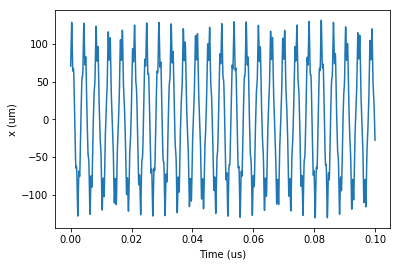

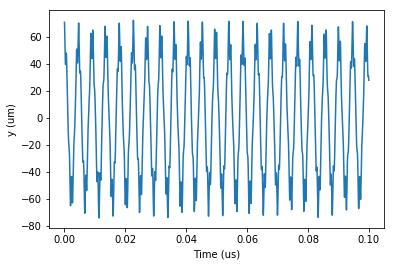

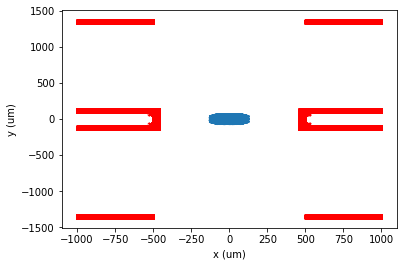

In [9]:
rho = 100.0e-6
phi = np.pi/4
T = 300.0
v = np.sqrt(2*kB*T/m)
theta = 0.0
dt = 1.0e-11
t_max = 1.0e-7
result = plot_traj(rho, phi, T, theta, dt, t_max)

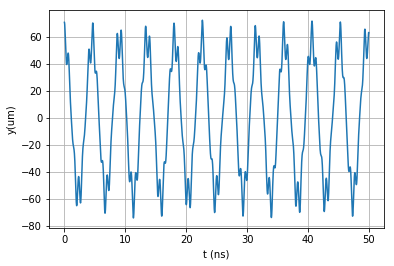

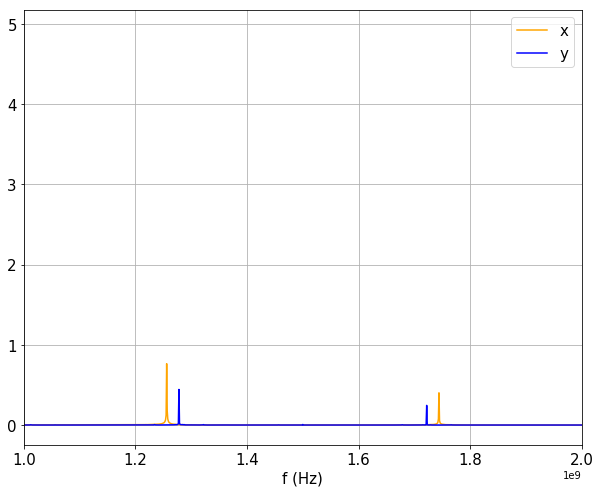

In [85]:
x, y, t = result
plt.figure()
plt.plot(t[0:5000]*1.0e9, y[0:5000]*1.0e6)
plt.xlabel("t (ns)")
plt.ylabel("y(um)")
plt.grid(True)

plt.figure(figsize=(10,8))
freq = fft.rfftfreq(t.shape[-1], 1.0e-11)
FT_x = fft.rfft(x)
FT_y = fft.rfft(y)
#plt.semilogx(freq, abs(FT_x), color='red',label='x', linewidth=1)
#plt.semilogx(freq, abs(FT_y), color='blue', label='y', linewidth=1)
plt.plot(freq, abs(FT_x), color='orange',label='x')
plt.plot(freq, abs(FT_y), color='blue', label='y')
plt.xlim(1.0e9, 20.0e8)
plt.xlabel("f (Hz)", fontsize=15)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, which='both')

In [55]:
start = time.time()
dt = 1.0e-11 #s
t_max = 50.0e-9 # maximum time duration of the simulation

#initial condition
rho_s = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
rho_s = np.array(rho_s) * 1.0e-6
N_samples = 200
N_phi = None
N_theta = None

# A dictionary, taking temperature as key and the value is a 
# list of success rates correspond to each rou in rou_s
success_rate = dict()
errors = dict()

for T in [5000.0, 1000.0, 300.0, 100.0, 20.0, 4.0]:
    v = np.sqrt(2*kB*T/m)
    success_rate[T] = [] 
    errors[T] = []
    print("Simulating T = ", T, "kelvin")
    for rho in rho_s:
        result = []
        phi = np.random.rand(N_samples) * np.pi * 2
        theta = np.random.rand(N_samples) * np.pi * 2
        for i in range(N_samples):
            success, x_f, y_f = trapped(rho, phi[i], v, theta[i], dt, t_max)
            event_log.append([rho, v, x_f, y_f, success])
            if success:
                result.append(1)
            else:
                result.append(0)
        success_rate[T].append(np.mean(result))
        errors[T].append(np.std(result)/np.sqrt(N_samples))
end = time.time() 
print("Program Run Time: ", round(end-start), "s")

Simulating T =  5000.0 kelvin
Simulating T =  1000.0 kelvin
Simulating T =  300.0 kelvin
Simulating T =  100.0 kelvin
Simulating T =  20.0 kelvin
Simulating T =  4.0 kelvin
Program Run Time:  11398 s


## Manipulate the event logs and plot useful things (final positions of electrons, phase diagrams etc.)

In [29]:
event_log_arr = np.array(event_log)
df_event = pd.DataFrame(event_log_arr, columns=['rho_0', 'v_0', 'x_f', 'y_f', 'trapped'])

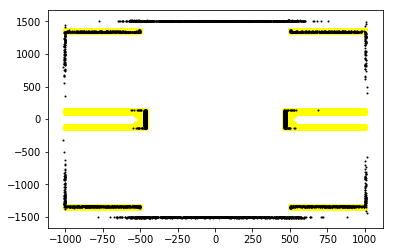

In [30]:
x_fail = df_event[df_event.trapped == 0.0].x_f.values
y_fail = df_event[df_event.trapped == 0.0].y_f.values

electrode = df_RF.loc[(np.abs(df_RF["Ex"]) < 1.0e-8) & (np.abs(df_RF["Ey"]) < 1.0e-8)]
x_electrode = electrode.iloc[:, 0].values
y_electrode = electrode.iloc[:, 1].values
plt.plot(x_electrode*1.0e6, y_electrode*1.0e6, ".", color='yellow')
plt.plot(-x_electrode*1.0e6, y_electrode*1.0e6, ".", color='yellow')
plt.plot(x_electrode*1.0e6, -y_electrode*1.0e6, ".", color='yellow')
plt.plot(-x_electrode*1.0e6, -y_electrode*1.0e6, ".", color='yellow')
plt.plot(x_fail*1.0e6, y_fail*1.0e6, '.', markersize=2, color='black')

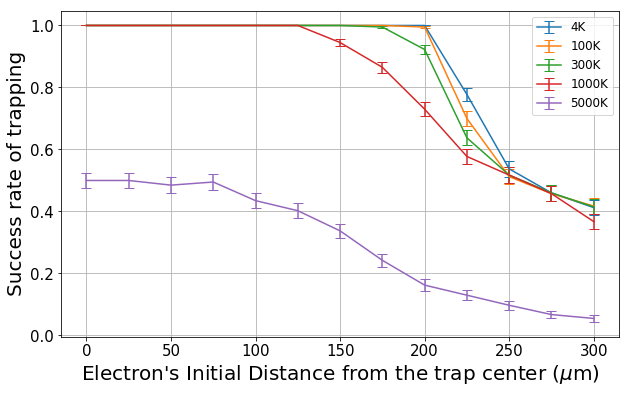

In [66]:
plt.figure(figsize=(10, 6))
vs = df_event.v_0.unique()
vs.sort()
for v in vs:
    T = 0.5*m*v**2/kB
    if round(T) == 20:
        continue
    rhos = df_event[df_event.v_0 == v].rho_0.unique()
    rhos.sort()
    success_rate = []
    err = []
    for rho in rhos:
        mean = df_event[(df_event.v_0==v) & (df_event.rho_0==rho)].iloc[:, 4].mean()
        std = df_event[(df_event.v_0==v) & (df_event.rho_0==rho)].iloc[:, 4].std()
        N = df_event[(df_event.v_0==v) & (df_event.rho_0==rho)].shape[0]
        success_rate.append(mean)
        err.append(std/np.sqrt(N))
    plt.errorbar(rhos*1.0e6, success_rate, yerr=err, label = str(int(round(T))) + "K", capsize=5)
    #plt.plot(rhos*1.0e6, success_rate, label = str(round(T)) + "K")
plt.grid(True)  
plt.xlabel("Electron's Initial Distance from the trap center ($\mu$m)", fontsize=20)
plt.ylabel("Success rate of trapping", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=12)
plt.show()

In [60]:
a = np.array([[1,2,300],[4000,5,6],[7,8,9]])

# writing out the result
file = open("event_log_RF+DC(actual)_trap.txt","w") 
file.write("rho, v, x_final, y_final, successful trapping\n")
for row in event_log:
    for elem in row:
        file.write(str(float(elem))+" ")
    file.write("\n")
file.close()

In [2]:
# event_log = np.loadtxt("event_log_RF+DC(actual)_trap.txt", skiprows=1)